# Tutorial 01

## basics of wrapped-in pseudo-$C_\ell$ estimator

By default we use [NaMaster](https://github.com/LSSTDESC/NaMaster).

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.tools.ps_estimator import pstimator
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
NSIDE = 128
APOSCALE = 6.
LMIN = 30
LMAX = 210
PSBIN = 6

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
np.random.seed(0)
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
cmb_cl = hp.anafast(mapcmb)[:3]
map23 = map23f + mapcmb
map353 = map353f + mapcmb

mapcmb = hp.smoothing(mapcmb,fwhm=np.deg2rad(52.8/60.),verbose=0)

mask = hp.read_map('./data/ali_mask.fits',dtype=np.float32,verbose=0)

#### use `pstimator` functions (with NaMaster support)

- call the `pstimator` only once

(10, 384)

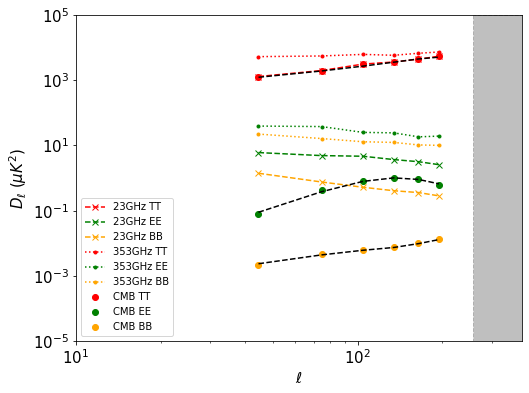

In [3]:
est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,lmin=LMIN,lmax=LMAX,psbin=PSBIN)

est.targets=('TT',)
auto_cmb_t = est.autoBP(mapcmb,beams=np.deg2rad(52.8/60.))
est.targets=('EE',)
auto_cmb_e = est.autoBP(mapcmb,beams=np.deg2rad(52.8/60.))
est.targets=('BB',)
auto_cmb_b = est.autoBP(mapcmb,beams=np.deg2rad(52.8/60.))

est.targets=('TT',)
auto_23_t = est.autoBP(map23)
est.targets=('EE','BB')
auto_23_eb = est.autoBP(map23)

est.targets=('TT',)
auto_353_t = est.autoBP(map353)
est.targets=('EE','BB')
auto_353_eb = est.autoBP(map353)

# calculate binned CMB band-power from input Cl
cmb_dl = est.bpconvert(cmb_cl[:,:est.lmax+1])

fig,ax = plt.subplots(figsize=(8,6))

ax.scatter(auto_cmb_t[0],auto_cmb_t[1],
           color='red',marker='o',label=r'CMB TT')
ax.scatter(auto_cmb_e[0],auto_cmb_e[1],
           color='green',marker='o',label=r'CMB EE')
ax.scatter(auto_cmb_b[0],auto_cmb_b[1],
           color='orange',marker='o',label=r'CMB BB')

ax.plot(auto_23_t[0],auto_23_t[1],
        color='red',linestyle='--',marker='x',label=r'23GHz TT')
ax.plot(auto_23_eb[0],auto_23_eb[1],
        color='green',linestyle='--',marker='x',label=r'23GHz EE')
ax.plot(auto_23_eb[0],auto_23_eb[2],
        color='orange',linestyle='--',marker='x',label=r'23GHz BB')

ax.plot(auto_353_t[0],auto_353_t[1],
        color='red',linestyle=':',marker='.',label=r'353GHz TT')
ax.plot(auto_353_eb[0],auto_353_eb[1],
        color='green',linestyle=':',marker='.',label=r'353GHz EE')
ax.plot(auto_353_eb[0],auto_353_eb[2],
        color='orange',linestyle=':',marker='.',label=r'353GHz BB')

ax.plot(est.modes,cmb_dl[0],color='k',linestyle='--')
ax.plot(est.modes,cmb_dl[1],color='k',linestyle='--')
ax.plot(est.modes,cmb_dl[2],color='k',linestyle='--')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-5,1e-5),(1e5,1e5),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-5,1.e5))
ax.set_xlim((10,3*NSIDE))

- PS estimator function correctness check, here we utilize **workspace** recorded from the previous runs of `pstimator`.

(10, 384)

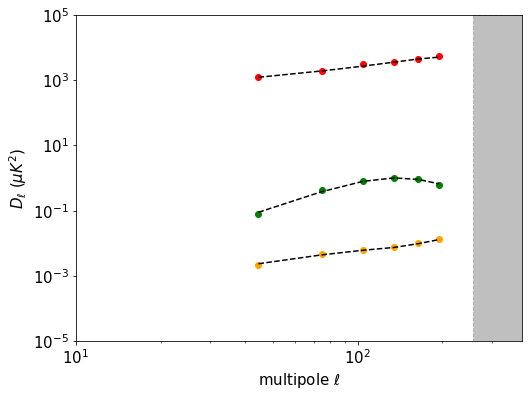

In [4]:
est.targets=('TT',)
wsp = est.autoWSP(mapcmb,beams=np.deg2rad(52.8/60.))
auto_cmb_t = est.autoBP(mapcmb,wsp,beams=np.deg2rad(52.8/60.))
est.targets=('EE','BB')
wsp = est.autoWSP(mapcmb,beams=np.deg2rad(52.8/60.))
auto_cmb_eb = est.autoBP(mapcmb,wsp,beams=np.deg2rad(52.8/60.))

fig,ax = plt.subplots(figsize=(8,6))

ax.scatter(auto_cmb_t[0],auto_cmb_t[1],
           color='red',marker='o')
ax.scatter(auto_cmb_eb[0],auto_cmb_eb[1],
           color='green',marker='o')
ax.scatter(auto_cmb_eb[0],auto_cmb_eb[2],
           color='orange',marker='o')

ax.plot(est.modes,cmb_dl[0],color='k',linestyle='--')
ax.plot(est.modes,cmb_dl[1],color='k',linestyle='--')
ax.plot(est.modes,cmb_dl[2],color='k',linestyle='--')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-5,1e-5),(1e5,1e5),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
#ax.legend(loc=3)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-5,1.e5))
ax.set_xlim((10,3*NSIDE))

(10, 384)

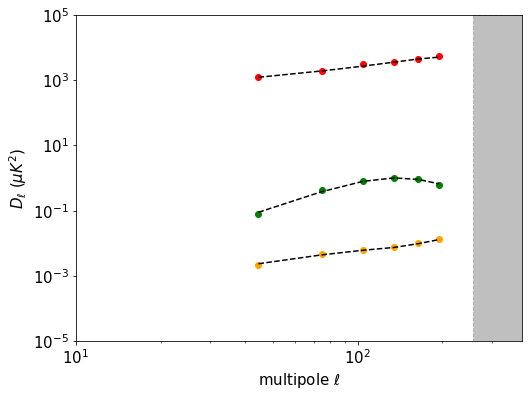

In [5]:
est.targets=('TT',)
wsp = est.crosWSP(np.vstack([mapcmb,mapcmb]),beams=[np.deg2rad(52.8/60.),np.deg2rad(52.8/60.)])
cross_cmb_t = est.crosBP(np.vstack([mapcmb,mapcmb]),wsp,beams=[np.deg2rad(52.8/60.),np.deg2rad(52.8/60.)])
est.targets=('EE','BB')
wsp = est.crosWSP(np.vstack([mapcmb,mapcmb]),beams=[np.deg2rad(52.8/60.),np.deg2rad(52.8/60.)])
cross_cmb_eb = est.crosBP(np.vstack([mapcmb,mapcmb]),wsp,beams=[np.deg2rad(52.8/60.),np.deg2rad(52.8/60.)])

fig,ax = plt.subplots(figsize=(8,6))

ax.scatter(cross_cmb_t[0],cross_cmb_t[1],
           color='red',marker='o')
ax.scatter(cross_cmb_eb[0],cross_cmb_eb[1],
           color='green',marker='o')
ax.scatter(cross_cmb_eb[0],cross_cmb_eb[2],
           color='orange',marker='o')

ax.plot(est.modes,cmb_dl[0],color='k',linestyle='--')
ax.plot(est.modes,cmb_dl[1],color='k',linestyle='--')
ax.plot(est.modes,cmb_dl[2],color='k',linestyle='--')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-5,1e-5),(1e5,1e5),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
#ax.legend(loc=3)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-5,1.e5))
ax.set_xlim((10,3*NSIDE))

#### play with beams

In [6]:
FWHM = np.deg2rad(0.5)  # beam fwhm

map23_s = hp.smoothing(map23,fwhm=FWHM,verbose=0)
map23_s[:,mask<1.] = 0.

est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,lmin=LMIN,lmax=LMAX,psbin=PSBIN,targets=('TT',))
auto_23_t = est.autoBP(map23)
auto_23_s0 = est.autoBP(map23_s)
auto_23_s1 = est.autoBP(map23_s,beams=FWHM)

map23_q = hp.smoothing(map23,fwhm=2*FWHM,verbose=0)
map23_q[:,mask<1.] = 0.

auto_23_q0 = est.autoBP(map23_q)
auto_23_q1 = est.autoBP(map23_q,beams=2*FWHM)

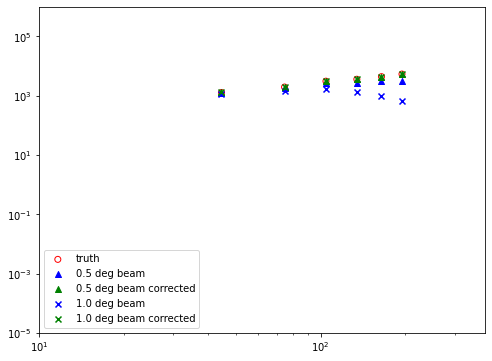

In [7]:
fig,ax = plt.subplots(figsize=(8,6))

ax.scatter(auto_23_t[0],auto_23_t[1],color='red',marker='o',facecolors='none',label='truth')
ax.scatter(auto_23_s0[0],auto_23_s0[1],color='blue',marker='^',label=str(FWHM*180./np.pi)+' deg beam')
ax.scatter(auto_23_s1[0],auto_23_s1[1],color='green',marker='^',label=str(FWHM*180./np.pi)+' deg beam corrected')
ax.scatter(auto_23_q0[0],auto_23_q0[1],color='blue',marker='x',label=str(2*FWHM*180./np.pi)+' deg beam')
ax.scatter(auto_23_q1[0],auto_23_q1[1],color='green',marker='x',label=str(2*FWHM*180./np.pi)+' deg beam corrected')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim((1.e-5,1.e+6))
ax.set_xlim((10,3*NSIDE))
ax.legend(loc=3)

#### play with inhomogeneous noise

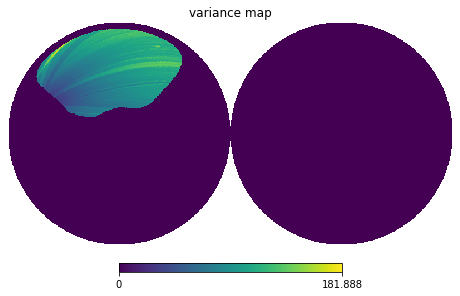

In [8]:
noise353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
noise353[:,mask<1.] = 0.

fig = plt.figure(figsize=(8,6))
hp.orthview(noise353[0],rot=[0,90],title='variance map',hold=True)

In [9]:
%%time
NSAMP = 10
auto_353_nt = np.zeros((NSAMP,len(auto_353_t[0])))
auto_353_ne = np.zeros((NSAMP,len(auto_353_t[0])))
auto_353_nb = np.zeros((NSAMP,len(auto_353_t[0])))
noise_353_t = np.zeros((NSAMP,len(auto_353_t[0])))
noise_353_e = np.zeros((NSAMP,len(auto_353_t[0])))
noise_353_b = np.zeros((NSAMP,len(auto_353_t[0])))
for i in range(NSAMP):
    n = np.random.normal(size=noise353.shape)*np.sqrt(noise353)
    map353n = map353+n
    est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,lmin=LMIN,lmax=LMAX,psbin=PSBIN)
    auto_353_nt[i] = est.autoBP_TT(map353n)[1]
    auto_353_ne[i] = est.autoBP_EE(map353n)[1]
    auto_353_nb[i] = est.autoBP_BB(map353n)[1]
    noise_353_t[i] = est.autoBP_TT(n)[1]
    noise_353_e[i] = est.autoBP_EE(n)[1]
    noise_353_b[i] = est.autoBP_BB(n)[1]

CPU times: user 16min 7s, sys: 323 ms, total: 16min 8s
Wall time: 4min 3s


(10, 384)

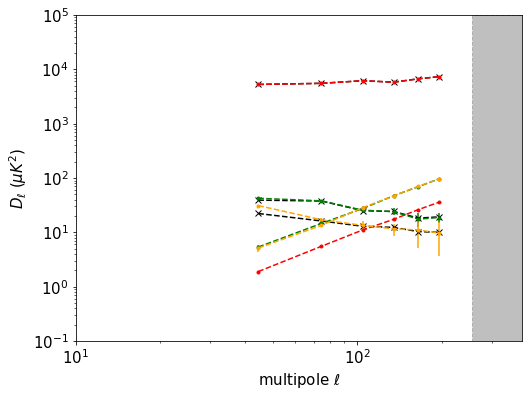

In [10]:
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(auto_353_t[0],auto_353_t[1],
        color='k',linestyle='--',marker='x',label=r'353GHz TT')
ax.plot(auto_353_eb[0],auto_353_eb[1],
        color='k',linestyle='--',marker='x',label=r'353GHz EE')
ax.plot(auto_353_eb[0],auto_353_eb[2],
        color='k',linestyle='--',marker='x',label=r'353GHz BB')

ax.errorbar(auto_353_t[0],np.mean(auto_353_nt,axis=0)-np.mean(noise_353_t,axis=0),np.std(auto_353_nt,axis=0),
            color='red',linestyle='--',marker='.')
ax.errorbar(auto_353_eb[0],np.mean(auto_353_ne,axis=0)-np.mean(noise_353_e,axis=0),np.std(auto_353_ne,axis=0),
            color='green',linestyle='--',marker='.')
ax.errorbar(auto_353_eb[0],np.mean(auto_353_nb,axis=0)-np.mean(noise_353_b,axis=0),np.std(auto_353_nb,axis=0),
            color='orange',linestyle='--',marker='.')

ax.plot(auto_353_t[0],np.mean(noise_353_t,axis=0),np.std(noise_353_t,axis=0),
        color='red',linestyle='--',marker='.')
ax.errorbar(auto_353_eb[0],np.mean(noise_353_e,axis=0),np.std(noise_353_e,axis=0),
            color='green',linestyle='--',marker='.')
ax.errorbar(auto_353_eb[0],np.mean(noise_353_b,axis=0),np.std(noise_353_b,axis=0),
            color='orange',linestyle='--',marker='.')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-5,1e-5),(1e5,1e5),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-1,1.e5))
ax.set_xlim((10,3*NSIDE))

end